# This notebook is to code and execute entanglement swappping CHSH-3 experiment.

What is happening is like this:  
1. Entangle Alice's and Bob's qubits 
2. Entangle Charile's and Bobs's qubit  
3. Bob execute Bell meausurements which make Alice's and Bob's qubits one of four possible entangled state    
4. Alice and Bob execute CHSH-3 measurement and see whether result violate any important boundaries.  

Most of ideas of this code are from https://qiskit.org/textbook/ch-demos/chsh.html : Local Reality and the CHSH Inequality

In [3]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
import numpy as np
#import python stuff
import matplotlib.pyplot as plt
import numpy as np

In [2]:
if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='ibm-3', project='korea-hackathon-')
device = provider.get_backend('ibmq_quito')
layout = list(range(4))

In [3]:
from qiskit.providers.aer import AerSimulator
sim = AerSimulator.from_backend(device)
sim2 = Aer.get_backend('aer_simulator')

Below code is a function to create our CHSH circuit between Alice and Charlie.
While Charile (q1) always measures either in the X, Y, Z basis, Alice's measurement basis rotates by the angle θ with respect to Charile's in either Z-X or Z-Y or X-Y planes.

In [4]:
def make_chsh_circuit(theta_vec, meas):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        q1 = QuantumRegister(size=1, name='alice')
        q3 = QuantumRegister(size=1, name='charlie')
        q2 = QuantumRegister(size=2, name='bob')
        cr = ClassicalRegister(size=4)
        for el in obs_vec:
            qc = QuantumCircuit(q1, q3, q2, cr)
            qc.h(0)
            qc.h(1)
            qc.cx(0,2)
            qc.cx(1,3)
            qc.cx(2,3)
            qc.h(2)
            qc.measure(2,2)
            qc.measure(3,3)
            qc.barrier()            
            if meas=='ZX':
                qc.ry(theta, 0)
                qc.h(0)
                for i in range(2):
                    if el[i] == '1':
                        qc.h(i)
            elif meas=='ZY':
                
                qc.rx(theta, 0)
                for i in range(2):
                    if el[i] == '1':
                        qc.rx((np.pi)/2,i) 
                        qc.z(i)
            elif meas=='XY':
                qc.rz(-theta, 0)

                for i in range(2):
                    if el[i] == '1':
                        qc.y(i)
                        qc.rz((-np.pi)/2,i)
                qc.h(0)
                qc.h(1)
            else:
                pass

            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits
     
def make_chsh_circuit_ZX(theta_vec):
    return make_chsh_circuit(theta_vec=theta_vec, meas='ZX')

def make_chsh_circuit_ZY(theta_vec):
    return make_chsh_circuit(theta_vec=theta_vec, meas='ZY')

def make_chsh_circuit_XY(theta_vec):
    return make_chsh_circuit(theta_vec=theta_vec, meas='XY')

This function is to assing corresponding weight(-1 or +1) to results

In [5]:
def compute_chsh_witness(counts, meas):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    CHSH = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh = 0

        if meas=='1':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xx[element]
        
        elif meas=='2':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*xx[element]

        elif meas=='3':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xx[element]
        elif meas=='4':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*xx[element]

        CHSH.append(chsh/no_shots)

    return CHSH

def compute_chsh_witness1(counts):
    return compute_chsh_witness(counts=counts, meas='1')

def compute_chsh_witness2(counts):
    return compute_chsh_witness(counts=counts, meas='2')

def compute_chsh_witness3(counts):
    return compute_chsh_witness(counts=counts, meas='3')

def compute_chsh_witness4(counts):
    return compute_chsh_witness(counts=counts, meas='4')


We are going to split the interval (0 2π] into 15 angles and build the corresponding set of CHSH circuits.

In [5]:
number_of_thetas = 15
theta_vec = np.linspace(0, 2*np.pi, number_of_thetas)
my_chsh_circuitsZX = make_chsh_circuit_ZX(theta_vec)
my_chsh_circuitsZY = make_chsh_circuit_ZY(theta_vec)
my_chsh_circuitsXY = make_chsh_circuit_XY(theta_vec)

Let's see some of our cirucuits.

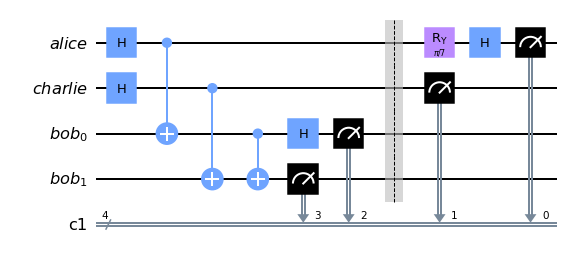

In [6]:
my_chsh_circuitsZX[4].draw(output='mpl')

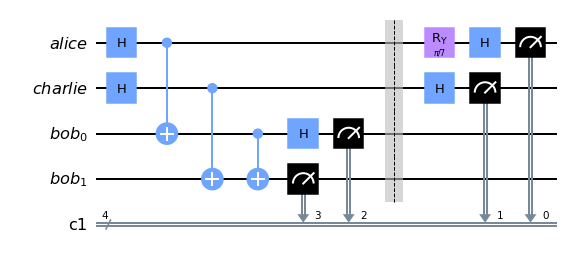

In [7]:
my_chsh_circuitsZX[5].draw(output='mpl')

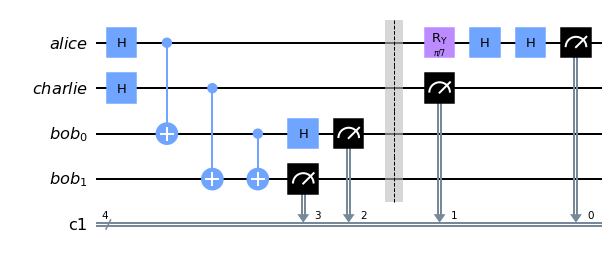

In [8]:
my_chsh_circuitsZX[6].draw(output='mpl')

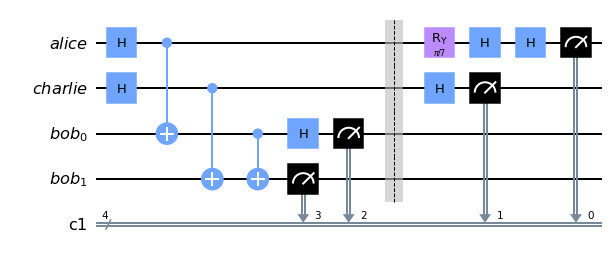

In [9]:
my_chsh_circuitsZX[7].draw(output='mpl')

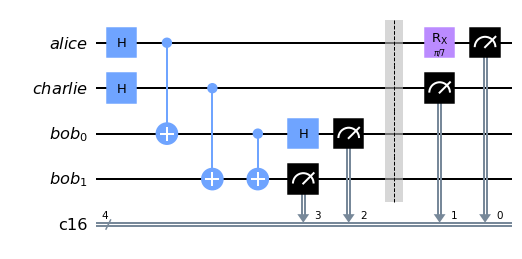

In [10]:
my_chsh_circuitsZY[4].draw(output='mpl')

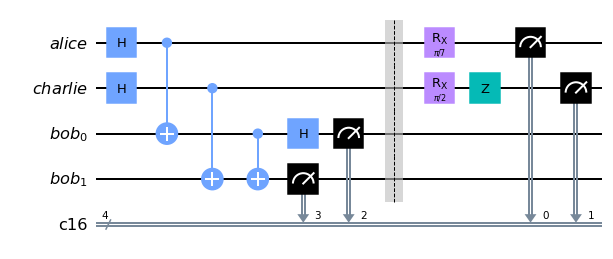

In [11]:
my_chsh_circuitsZY[5].draw(output='mpl')

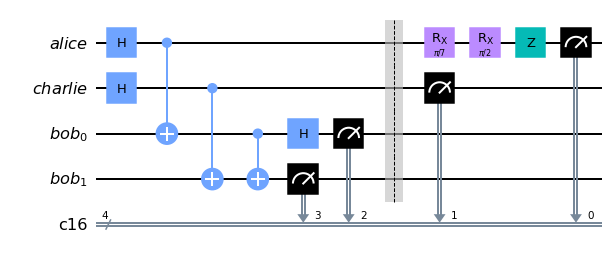

In [12]:
my_chsh_circuitsZY[6].draw(output='mpl')

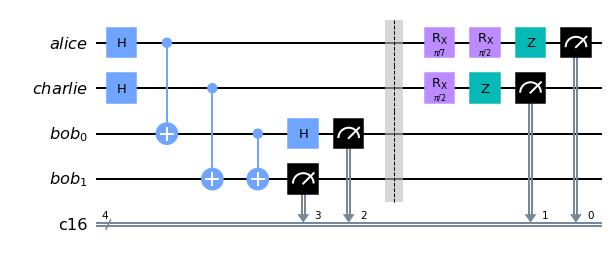

In [13]:
my_chsh_circuitsZY[7].draw(output='mpl')

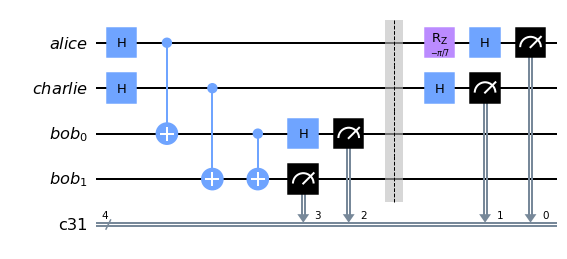

In [14]:
my_chsh_circuitsXY[4].draw(output='mpl')

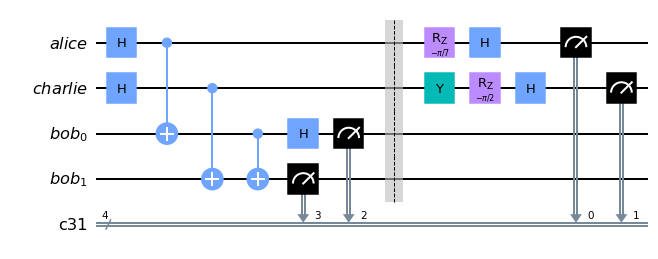

In [15]:
my_chsh_circuitsXY[5].draw(output='mpl')

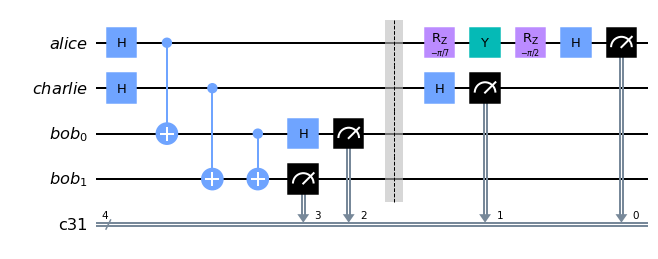

In [16]:
my_chsh_circuitsXY[6].draw(output='mpl')

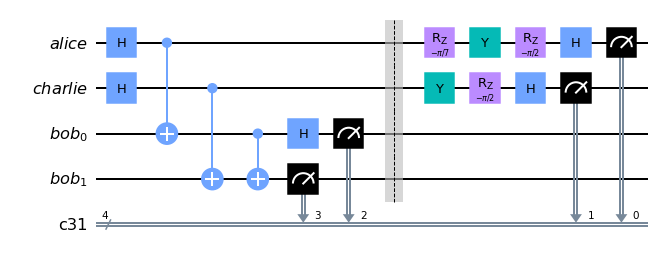

In [17]:
my_chsh_circuitsXY[7].draw(output='mpl')

We are going to execute our circuits in both Aer simulator and real quantum device.   
After that we are matching each data to corresponding Bob's measurement output which determines Alice's and Charile's entanglement states.

In [7]:
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter, TensoredMeasFitter
import qiskit.tools.jupyter
%qiskit_job_watcher

quantum_instance0 = QuantumInstance(backend=device, shots=2**13, optimization_level=2)
quantum_instance1 = QuantumInstance(backend=device, shots=2**13, optimization_level=2, initial_layout=layout)
quantum_instance2 = QuantumInstance(backend=sim2, shots=2**18, optimization_level=2)

# Execute and get counts
result_noiseZX = quantum_instance1.execute(my_chsh_circuitsZX)
result_noiseZY = quantum_instance1.execute(my_chsh_circuitsZY)
result_noiseXY = quantum_instance1.execute(my_chsh_circuitsXY)

result_noiseZX00_ls=result_noiseZX.get_counts()
result_noiseZY00_ls=result_noiseZY.get_counts()
result_noiseXY00_ls=result_noiseXY.get_counts()

result_noiseZX01_ls=result_noiseZX.get_counts()
result_noiseZY01_ls=result_noiseZY.get_counts()
result_noiseXY01_ls=result_noiseXY.get_counts()

result_noiseZX10_ls=result_noiseZX.get_counts()
result_noiseZY10_ls=result_noiseZY.get_counts()
result_noiseXY10_ls=result_noiseXY.get_counts()

result_noiseZX11_ls=result_noiseZX.get_counts()
result_noiseZY11_ls=result_noiseZY.get_counts()
result_noiseXY11_ls=result_noiseXY.get_counts()
######################################################################
result_idealZX = quantum_instance2.execute(my_chsh_circuitsZX)
result_idealZY = quantum_instance2.execute(my_chsh_circuitsZY)
result_idealXY = quantum_instance2.execute(my_chsh_circuitsXY)

result_idealZX00_ls=result_idealZX.get_counts()
result_idealZY00_ls=result_idealZY.get_counts()
result_idealXY00_ls=result_idealXY.get_counts()

result_idealZX01_ls=result_idealZX.get_counts()
result_idealZY01_ls=result_idealZY.get_counts()
result_idealXY01_ls=result_idealXY.get_counts()

result_idealZX10_ls=result_idealZX.get_counts()
result_idealZY10_ls=result_idealZY.get_counts()
result_idealXY10_ls=result_idealXY.get_counts()

result_idealZX11_ls=result_idealZX.get_counts()
result_idealZY11_ls=result_idealZY.get_counts()
result_idealXY11_ls=result_idealXY.get_counts()

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

/home/quic/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


This is for erasing uneccessary outputs from our results sorted by Bob's meausreuments (00, 01, 10, 11)

In [ ]:
# Bob의 상태에 따라 분류했어요

for item in result_idealZX00_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealZY00_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealXY00_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
###########################################
for item in result_idealZX01_ls:
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealZY01_ls:
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealXY01_ls:
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
#######################################
for item in result_idealZX10_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealZY10_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealXY10_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
################################
for item in result_idealZX11_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
for item in result_idealZY11_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
for item in result_idealXY11_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
########################################
########################################
for item in result_noiseZX00_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_noiseZY00_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_noiseXY00_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
###########################################
for item in result_noiseZX01_ls:
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_noiseZY01_ls:
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_noiseXY01_ls:
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
#######################################
for item in result_noiseZX10_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_noiseZY10_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_noiseXY10_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
################################
for item in result_noiseZX11_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
for item in result_noiseZY11_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
for item in result_noiseXY11_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('0000',None)
    item.pop('0001',None)
    item.pop('0010',None)
    item.pop('0011',None)
###########################
    

We have to assign corresponding weight(-1 or +1) for each outputs to calculate average values.

In [ ]:
CHSHZX_ideal00 = compute_chsh_witness1(result_idealZX00_ls)
CHSHZY_ideal00 = compute_chsh_witness4(result_idealZY00_ls)
CHSHXY_ideal00 = compute_chsh_witness4(result_idealXY00_ls)


CHSHZX_ideal01 = compute_chsh_witness3(result_idealZX01_ls) ### - 부호
CHSHZY_ideal01 = compute_chsh_witness3(result_idealZY01_ls) ### +theta 3 축 대칭
CHSHXY_ideal01 = compute_chsh_witness1(result_idealXY01_ls) ### +theta 3 축 대칭
CHSHZY_ideal01.reverse()
CHSHXY_ideal01.reverse()

CHSHZX_ideal10 = compute_chsh_witness3(result_idealZX10_ls) ### 
CHSHZY_ideal10 = compute_chsh_witness4(result_idealZY10_ls) ### - 부호
CHSHXY_ideal10 = compute_chsh_witness3(result_idealXY10_ls) ### +theta 3 축 대칭
CHSHXY_ideal10.reverse()

CHSHZX_ideal11 = compute_chsh_witness1(result_idealZX11_ls) ###  - 부호
CHSHZY_ideal11 = compute_chsh_witness3(result_idealZY11_ls) ###  - theata 3축 대칭
CHSHXY_ideal11 = compute_chsh_witness3(result_idealXY11_ls) ### -theta 3 축 대칭
CHSHXY_ideal11.reverse()
CHSHZY_ideal11.reverse()

CHSHZX_ideal=[0 for i in range(number_of_thetas)]
CHSHZY_ideal=[0 for i in range(number_of_thetas)]
CHSHXY_ideal=[0 for i in range(number_of_thetas)]
for i in range(number_of_thetas):
    CHSHZX_ideal[i]=(CHSHZX_ideal00[i]-CHSHZX_ideal01[i]+CHSHZX_ideal10[i]-CHSHZX_ideal11[i])/4
    CHSHZY_ideal[i]=(CHSHZY_ideal00[i]+CHSHZY_ideal01[i]-CHSHZY_ideal10[i]-CHSHZY_ideal11[i])/4
    CHSHXY_ideal[i]=(CHSHXY_ideal00[i]+CHSHXY_ideal01[i]+CHSHXY_ideal10[i]-CHSHXY_ideal11[i])/4
####################################################################################################################
CHSHZX_noise00 = compute_chsh_witness1(result_noiseZX00_ls)
CHSHZY_noise00 = compute_chsh_witness4(result_noiseZY00_ls)
CHSHXY_noise00 = compute_chsh_witness4(result_noiseXY00_ls)


CHSHZX_noise01 = compute_chsh_witness3(result_noiseZX01_ls) ### - 부호
CHSHZY_noise01 = compute_chsh_witness3(result_noiseZY01_ls) ### +theta 3 축 대칭
CHSHXY_noise01 = compute_chsh_witness1(result_noiseXY01_ls) ### +theta 3 축 대칭
CHSHZY_noise01.reverse()
CHSHXY_noise01.reverse()

CHSHZX_noise10 = compute_chsh_witness3(result_noiseZX10_ls) ### 
CHSHZY_noise10 = compute_chsh_witness4(result_noiseZY10_ls) ### - 부호
CHSHXY_noise10 = compute_chsh_witness3(result_noiseXY10_ls) ### +theta 3 축 대칭
CHSHXY_noise10.reverse()

CHSHZX_noise11 = compute_chsh_witness1(result_noiseZX11_ls) ###  - 부호
CHSHZY_noise11 = compute_chsh_witness3(result_noiseZY11_ls) ###  - theata 3축 대칭
CHSHXY_noise11 = compute_chsh_witness3(result_noiseXY11_ls) ### -theta 3 축 대칭
CHSHXY_noise11.reverse()
CHSHZY_noise11.reverse()

CHSHZX_noise=[0 for i in range(number_of_thetas)]
CHSHZY_noise=[0 for i in range(number_of_thetas)]
CHSHXY_noise=[0 for i in range(number_of_thetas)]
for i in range(number_of_thetas):
    CHSHZX_noise[i]=(CHSHZX_noise00[i]-CHSHZX_noise01[i]+CHSHZX_noise10[i]-CHSHZX_noise11[i])/4
    CHSHZY_noise[i]=(CHSHZY_noise00[i]+CHSHZY_noise01[i]-CHSHZY_noise10[i]-CHSHZY_noise11[i])/4
    CHSHXY_noise[i]=(CHSHXY_noise00[i]+CHSHXY_noise01[i]+CHSHXY_noise10[i]-CHSHXY_noise11[i])/4


We then plot the results.

First plot is for the Z-X bases.

Text(0, 0.5, 'CHSH witness')

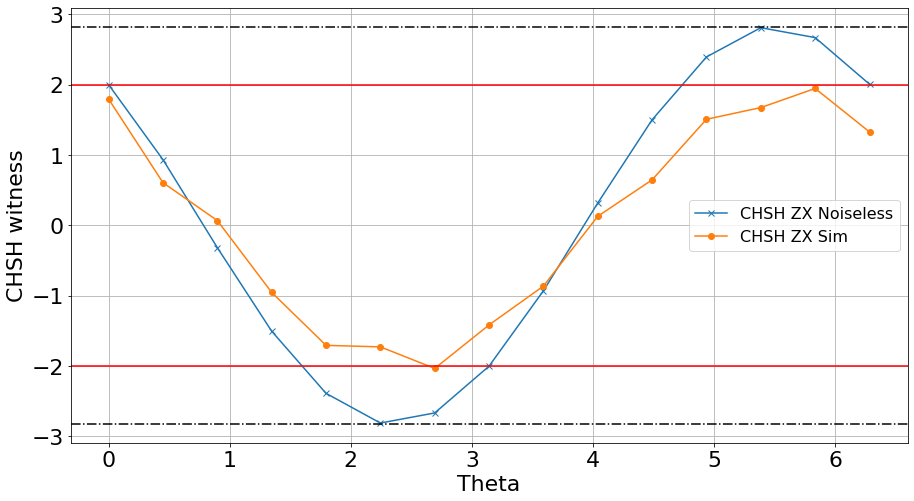

In [ ]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSHZX_ideal,'x-',label = 'CHSH ZX Noiseless')
plt.plot(theta_vec,CHSHZX_noise,'o-',label = 'CHSH ZX Sim')


plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Then for the Z-Y bases.

Text(0, 0.5, 'CHSH witness')

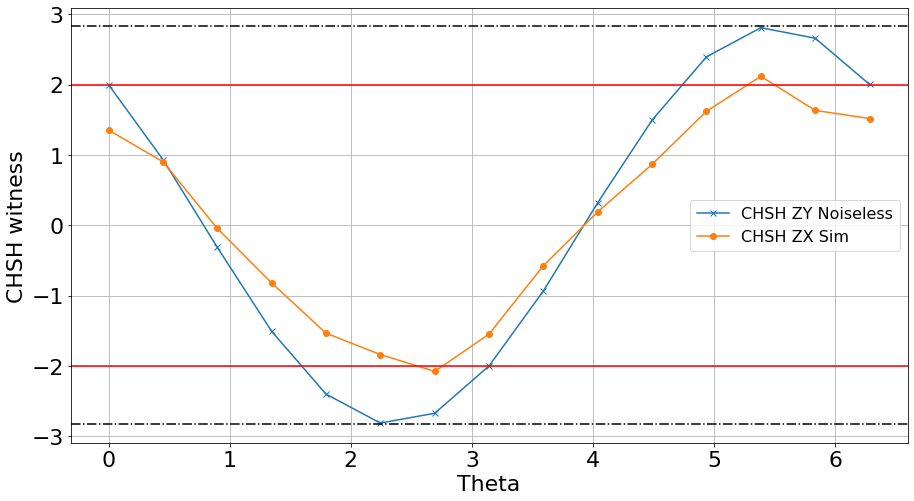

In [ ]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSHZY_ideal,'x-',label = 'CHSH ZY Noiseless')
plt.plot(theta_vec,CHSHZY_noise,'o-',label = 'CHSH ZX Sim')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Lastly for the X-Y bases.

Text(0, 0.5, 'CHSH witness')

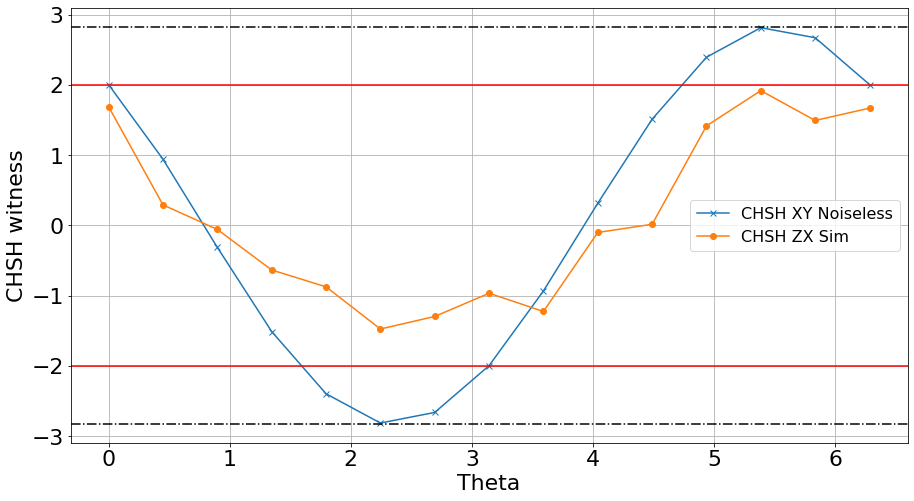

In [ ]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSHXY_ideal,'x-',label = 'CHSH XY Noiseless')
plt.plot(theta_vec,CHSHXY_noise,'o-',label = 'CHSH ZX Sim')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Finally we add all our plots and see CHSH-3 results.

Text(0, 0.5, 'CHSH witness')

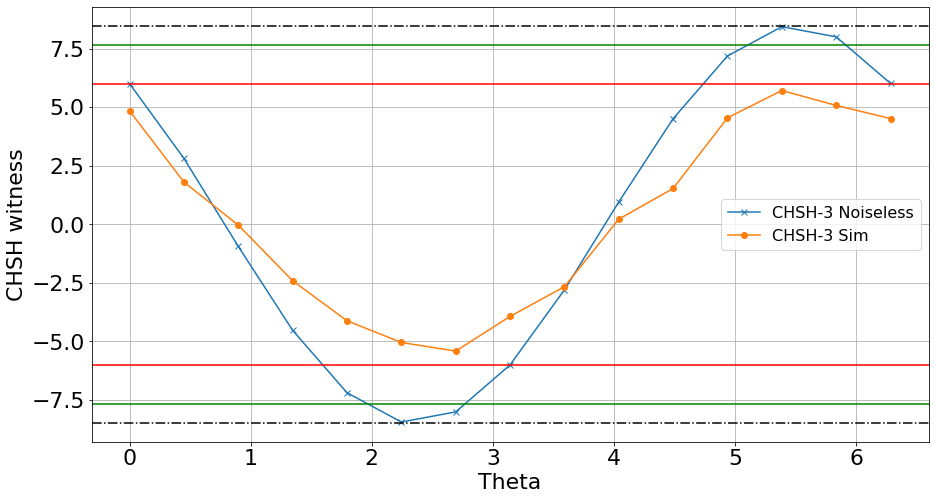

In [ ]:
CHSH3_ideal=[0 for i in range(number_of_thetas)]
for i in range(number_of_thetas):
    CHSH3_ideal[i]=CHSHZX_ideal[i]+CHSHZY_ideal[i]+CHSHXY_ideal[i]

    
CHSH3_noise=[0 for i in range(number_of_thetas)]
for i in range(number_of_thetas):
    CHSH3_noise[i]=CHSHZX_noise[i]+CHSHZY_noise[i]+CHSHXY_noise[i]    
    
    

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSH3_ideal,'x-',label = 'CHSH-3 Noiseless')
plt.plot(theta_vec,CHSH3_noise,'o-',label = 'CHSH-3 Sim')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=6, color='r', linestyle='-')
plt.axhline(y=-6, color='r', linestyle='-')
plt.axhline(y=7.66, color='g', linestyle='-')
plt.axhline(y=-7.66, color='g', linestyle='-')

plt.axhline(y=np.sqrt(2)*6, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*6, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

As we can see, if we use Aer simulator we easily reached maximum quantum value. 
However we couldnt reach even classical limit with real circuits. 
This could be because of noise. As you can see in Local Reality and the CHSH Inequality page results, real device has difficulty in crossing classical limit. 
Our experiments require more qubits and gates which can cause many kinds of noise. 

In [ ]:
theta_vec[np.array(CHSH3_ideal)==max(CHSH3_ideal)]/np.pi

array([1.71428571])